In [10]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [11]:
import EncoderFactory
from DatasetManager import DatasetManager
import BucketFactory
import stability as st #Nogueira, Sechidis, Brown.

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict
import random
import joblib

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;

import shap

import warnings
warnings.filterwarnings('ignore')

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
dataset_ref = "bpic2012"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "single"
cls_encoding = "agg"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = True
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
max_feat = 10

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"]
    #"insurance": ["insurance_activity", "insurance_followup"],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['bpic2012_accepted']

Bucket 1


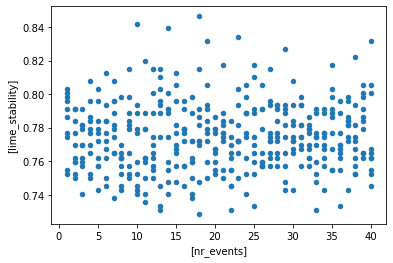

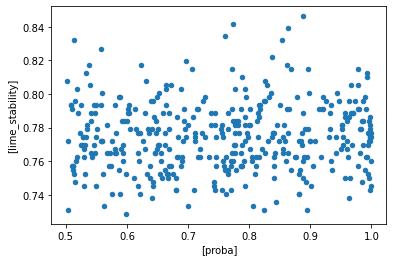

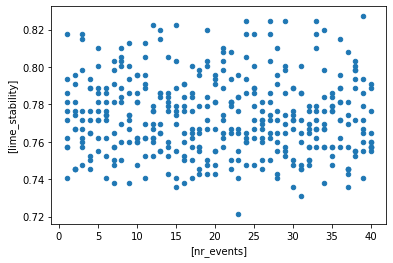

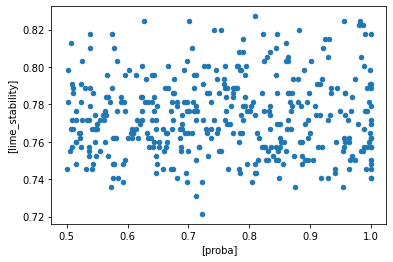

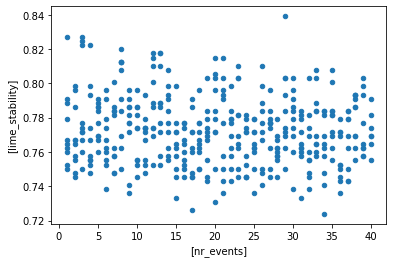

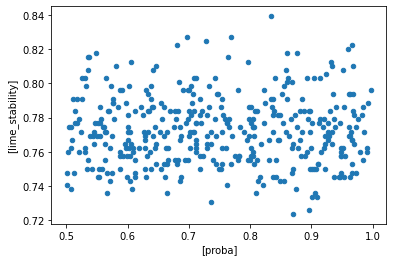

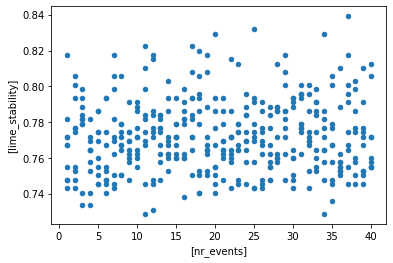

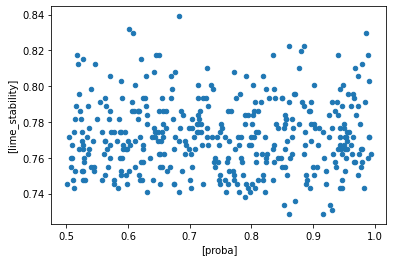

In [24]:
for dataset_name in datasets:

    dataset_manager = DatasetManager(dataset_name)

    for ii in range(n_iter):
        num_buckets = range(len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))]))

        for bucket in list(num_buckets):
            bucketID = bucket+1
            print ('Bucket', bucketID)

            #import everything needed to sort and predict
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls = joblib.load(cls_path)
            feature_combiner = joblib.load(feat_comb_path)

            #import previously identified samples
            tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            sample_instances = []

            with open (tn_path, 'rb') as f:
                tn_list = pickle.load(f)
            with open (tp_path, 'rb') as f:
                tp_list = pickle.load(f)
            with open (fn_path, 'rb') as f:
                fn_list = pickle.load(f)
            with open (fp_path, 'rb') as f:
                fp_list = pickle.load(f)

            #save results to a list
            sample_instances.append(tn_list)
            sample_instances.append(tp_list)
            sample_instances.append(fn_list)
            sample_instances.append(fp_list)
            
            for each in sample_instances:
                data = pd.DataFrame.from_records(each)
                data.plot(x = ['nr_events'], y = ['lime_stability'], kind = 'scatter', subplots = True, xlabel = 'Prefix Length', ylabel = 'Lime Stability')
                data.plot(x = ['proba'], y = ['lime_stability'], kind = 'scatter', subplots = True, xlabel = 'Prefix Length', ylabel = 'Prediction probability')